In [ ]:
import numpy as np
from itertools import product
import pickle

np.random.seed(41)

thetas1 = np.array([1, 1, 1])
thetas2 = np.array([1, 1, 1])
time_steps = 10
choices = 5

theta_hat = np.array(list(product([0, 1], repeat=3)))
print(f"theta_hat: \n{theta_hat}")

# Initialize lists to store data over time
ego_robust_prediction_outcomes = []
ego_sec_policy_outcomes = []
theta_hat_history = []
sigma_history = []
sigma_worst_history = []

gamma_history = []

for t in range(time_steps):
    print()
    print(f'Round {t}')
    
    # get costs
    A1 = np.round(np.random.uniform(0,1, size=(choices, choices)), 2)
    B1 = np.round(np.random.uniform(0,1, size=(choices, choices)), 2)
    C1 = np.round(np.random.uniform(0,1, size=(choices, choices)), 2)
    A2 = -A1
    B2 = B1
    C2 = C1
    
    # find composite matrices
    D1 = np.tensordot(thetas1, np.stack([A1, B1, C1]), axes=1)
    D2 = np.tensordot(thetas2, np.stack([A2, B2, C2]), axes=1)
    
    print()
    print(f"D1: \n{D1}")
    print()
    print(f"D2: \n{D2}")
    
    # predict all possible opponent security policies
    D2_hat = []
    sigma_hat = []
    for theta_combination in theta_hat:
        D2_instance = np.tensordot(theta_combination, np.stack([A2, B2, C2]), axes=1)
        D2_hat.append(D2_instance)
        sigma_instance = np.argmin(np.max(D2_instance, axis=0))
        sigma_hat.append(sigma_instance)
    
    print()
    print(f"sigma_hat: \n{sigma_hat}")
    
    # find the worst possible opponent policy, design best response
    worst_outcome = -1000
    gamma = None
    sigma_worst = None
    for sigma_possible in set(sigma_hat):
        outcome = np.min(D1[:][sigma_possible])
        if outcome > worst_outcome:
            worst_outcome = outcome
            sigma_worst = sigma_possible
            gamma = np.argmin(D1[:][sigma_possible])
    
    # observe actual policy
    sigma = np.argmin(np.max(D2, axis=0))
    ego_game_outcome = D1[gamma][sigma]
    
    gamma_s = np.argmin(np.max(D1, axis=1))
    ego_sec_outcome = D1[gamma_s][sigma]

    print()
    print(f'(gamma, sigma): {(gamma, sigma)}')
    print(f"sigma_worst: {sigma_worst}")
    print(f"ego_game_outcome: {ego_game_outcome}")
    
    # Store data
    ego_robust_prediction_outcomes.append(ego_game_outcome)
    ego_sec_policy_outcomes.append(ego_sec_outcome)
    theta_hat_history.append(theta_hat.copy())
    sigma_worst_history.append(sigma)
    sigma_history.append(sigma)
    gamma_history.append(gamma)
    
    # update possible theta space matching
    matching_sigma_indices = np.argwhere(np.array(sigma_hat) == sigma)
    theta_hat = theta_hat[matching_sigma_indices.ravel()]
    
    print()
    print(f"theta_hat after: \n{theta_hat}")

# Save the data
simulation_data = {
    'ego_outcomes': ego_robust_prediction_outcomes,    
    'ego_sec_policy_outcomes': ego_sec_policy_outcomes,
    'theta_hat_history': theta_hat_history,
    'sigma_history': sigma_history,
    'gamma_history': gamma_history,
    'time_steps': time_steps
}

# Save to pickle file
with open('game_theory_simulation_data.pkl', 'wb') as f:
    pickle.dump(simulation_data, f)

print("\nData saved to 'game_theory_simulation_data.pkl'")
print(f"Final ego outcomes: {ego_robust_prediction_outcomes}")
print(f"Final theta_hat size progression: {[len(th) for th in theta_hat_history]}")

theta_hat: 
[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]

Round 0

D1: 
[[1.22 1.32 1.86 0.83 1.14]
 [0.96 0.48 1.65 2.5  2.1 ]
 [1.47 1.77 1.88 1.94 0.73]
 [0.66 1.69 1.04 1.69 0.96]
 [1.33 2.12 1.68 1.11 0.89]]

D2: 
[[ 0.72  1.22  0.5   0.75  0.9 ]
 [-0.24  0.1   0.31  0.66  1.26]
 [ 0.81  1.21  1.5   1.3  -0.23]
 [ 0.52  0.29  0.42  0.19  0.16]
 [ 0.11  0.66  0.84  0.33  0.43]]

sigma_hat: 
[0, 4, 0, 0, 2, 4, 0, 0]

(gamma, sigma): (4, 0)
sigma_worst: 4
ego_game_outcome: 1.33

theta_hat after: 
[[0 0 0]
 [0 1 0]
 [0 1 1]
 [1 1 0]
 [1 1 1]]

Round 1

D1: 
[[1.56 1.57 1.83 1.82 1.52]
 [0.53 1.38 2.16 1.78 0.52]
 [1.55 1.17 1.58 1.21 1.57]
 [0.81 1.14 1.12 0.8  0.98]
 [2.48 1.72 0.97 0.69 0.59]]

D2: 
[[ 1.16  0.85  0.43  0.34  0.16]
 [ 0.33  1.    1.12  0.06  0.46]
 [ 1.17 -0.49  0.04  0.15 -0.25]
 [-0.05  0.16  0.16  0.5  -0.14]
 [ 1.42 -0.06  0.73  0.57 -0.07]]

sigma_hat: 
[0, 4, 4, 3, 4]

(gamma, sigma): (4, 4)
sigma_worst: 0
ego_game_outcome: 0.59

th

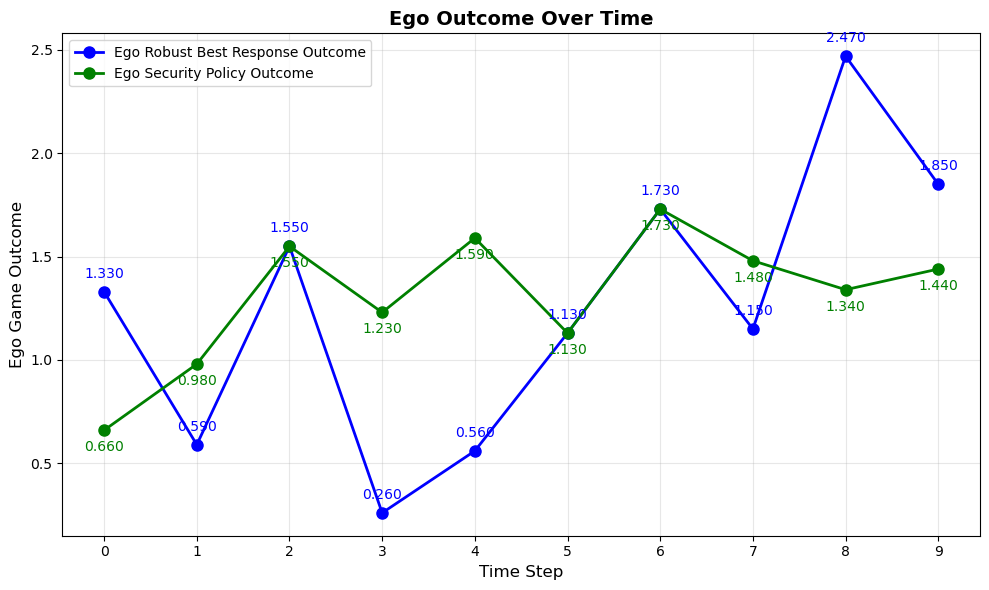

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load the saved data
with open('game_theory_simulation_data.pkl', 'rb') as f:
    data = pickle.load(f)

ego_outcomes = data['ego_outcomes']
ego_sec_policy_outcomes = data['ego_sec_policy_outcomes']
time_steps = data['time_steps']

# Plot 1: Ego Outcome Over Time
plt.figure(figsize=(10, 6))
plt.plot(range(time_steps), ego_outcomes, 'b-o', linewidth=2, markersize=8, label='Ego Robust Best Response Outcome')
plt.plot(range(time_steps), ego_sec_policy_outcomes, 'g-o', linewidth=2, markersize=8, label='Ego Security Policy Outcome')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Ego Game Outcome', fontsize=12)
plt.title('Ego Outcome Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(time_steps))
plt.legend()

# Add value labels on points for ego_outcomes
for i, outcome in enumerate(ego_outcomes):
    plt.annotate(f'{outcome:.3f}', (i, outcome), 
                textcoords="offset points", xytext=(0,10), ha='center', color='blue')

# Add value labels on points for ego_sec_policy_outcomes
for i, outcome in enumerate(ego_sec_policy_outcomes):
    plt.annotate(f'{outcome:.3f}', (i, outcome), 
                textcoords="offset points", xytext=(0,-15), ha='center', color='green')

plt.tight_layout()
plt.show()


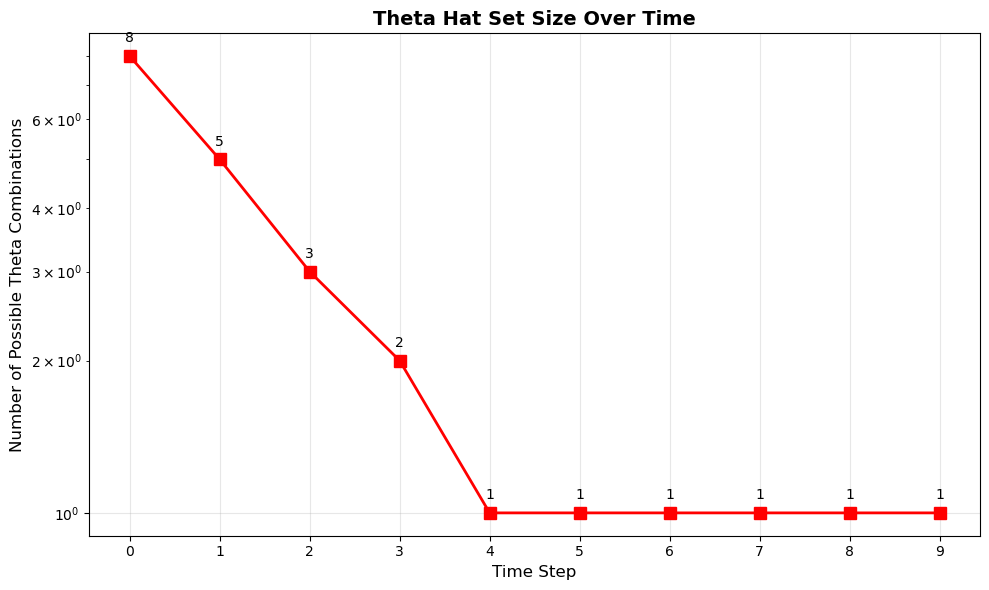

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load the saved data
with open('game_theory_simulation_data.pkl', 'rb') as f:
    data = pickle.load(f)

theta_hat_history = data['theta_hat_history']
time_steps = data['time_steps']

# Plot 2: Theta Hat Set Size Over Time
theta_hat_sizes = [len(theta_set) for theta_set in theta_hat_history]

plt.figure(figsize=(10, 6))
plt.plot(range(time_steps), theta_hat_sizes, 'r-s', linewidth=2, markersize=8)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Number of Possible Theta Combinations', fontsize=12)
plt.title('Theta Hat Set Size Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(time_steps))
plt.yscale('log')  # Log scale since it decreases exponentially

# Add value labels on points
for i, size in enumerate(theta_hat_sizes):
    plt.annotate(f'{size}', (i, size), 
                textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()


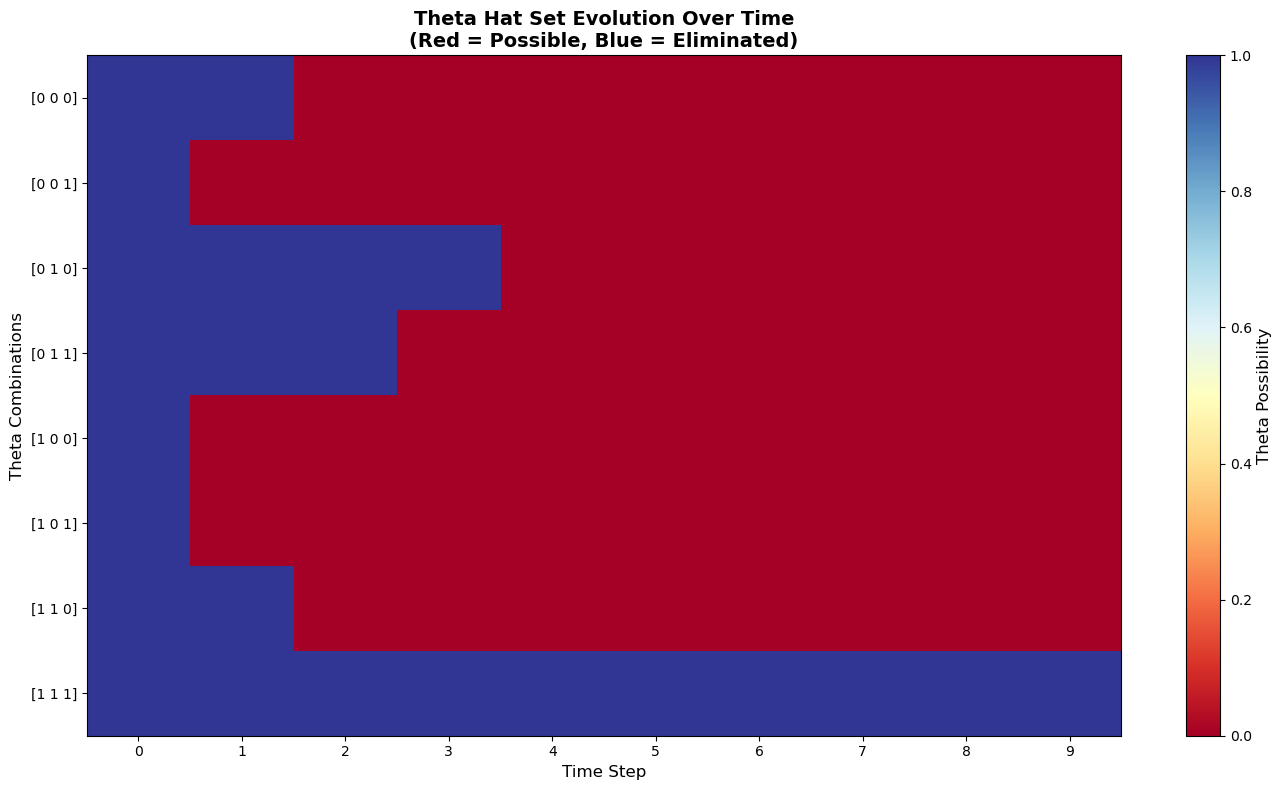

SIMULATION SUMMARY
Initial theta_hat size: 8
Final theta_hat size: 1
Final remaining theta combinations:
  [1 1 1]


In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from itertools import product

# Load the saved data
with open('game_theory_simulation_data.pkl', 'rb') as f:
    data = pickle.load(f)

theta_hat_history = data['theta_hat_history']
time_steps = data['time_steps']

# Plot 3: Theta Hat Evolution Heatmap
plt.figure(figsize=(14, 8))

# Create a heatmap-style visualization of theta_hat over time
all_possible_thetas = np.array(list(product([0, 1], repeat=3)))
theta_strings = [str(theta) for theta in all_possible_thetas]

# Create matrix to track which thetas are possible at each time step
theta_matrix = np.zeros((len(all_possible_thetas), time_steps))

for t in range(time_steps):
    current_theta_hat = theta_hat_history[t]
    for i, possible_theta in enumerate(all_possible_thetas):
        # Check if this theta is in the current theta_hat
        for theta in current_theta_hat:
            if np.array_equal(possible_theta, theta):
                theta_matrix[i, t] = 1
                break

# Create the heatmap
im = plt.imshow(theta_matrix, cmap='RdYlBu', aspect='auto')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Theta Combinations', fontsize=12)
plt.title('Theta Hat Set Evolution Over Time\n(Red = Possible, Blue = Eliminated)', 
          fontsize=14, fontweight='bold')
plt.yticks(range(len(theta_strings)), theta_strings)
plt.xticks(range(time_steps))

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Theta Possibility', fontsize=12)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 50)
print("SIMULATION SUMMARY")
print("=" * 50)
print(f"Initial theta_hat size: {len(theta_hat_history[0])}")
print(f"Final theta_hat size: {len(theta_hat_history[-1])}")
print(f"Final remaining theta combinations:")
for theta in theta_hat_history[-1]:
    print(f"  {theta}")


In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load the saved data
with open('game_theory_simulation_data.pkl', 'rb') as f:
    data = pickle.load(f)

sigma_history = data['sigma_history']
sigma_worst_history = data['sigma_worst_history']
time_steps = data['time_steps']

# Plot 4: Sigma vs Sigma Worst Over Time
plt.figure(figsize=(12, 8))

# Create subplot with two plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top plot: Line plot over time
ax1.plot(range(time_steps), sigma_history, 'b-o', linewidth=2, markersize=8, label='Actual Sigma (Observed)')
ax1.plot(range(time_steps), sigma_worst_history, 'r-s', linewidth=2, markersize=8, label='Sigma Worst (Predicted)')
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Policy Choice', fontsize=12)
ax1.set_title('Actual Sigma vs Predicted Sigma Worst Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(time_steps))
ax1.set_yticks(range(max(max(sigma_history), max(sigma_worst_history)) + 1))
ax1.legend()

# Add value labels on points
for i, (sigma, sigma_worst) in enumerate(zip(sigma_history, sigma_worst_history)):
    ax1.annotate(f'{sigma}', (i, sigma), 
                textcoords="offset points", xytext=(0,10), ha='center', color='blue')
    ax1.annotate(f'{sigma_worst}', (i, sigma_worst), 
                textcoords="offset points", xytext=(0,-15), ha='center', color='red')

# Bottom plot: Scatter plot to show correlation
ax2.scatter(sigma_history, sigma_worst_history, s=100, alpha=0.7, c=range(time_steps), cmap='viridis')
ax2.set_xlabel('Actual Sigma (Observed)', fontsize=12)
ax2.set_ylabel('Sigma Worst (Predicted)', fontsize=12)
ax2.set_title('Correlation between Actual Sigma and Predicted Sigma Worst', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add diagonal line for perfect prediction
max_val = max(max(sigma_history), max(sigma_worst_history))
ax2.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Perfect Prediction Line')
ax2.legend()

# Add colorbar for time progression
cbar = plt.colorbar(ax2.collections[0], ax=ax2)
cbar.set_label('Time Step', fontsize=12)

# Add time step labels to scatter points
for i, (sigma, sigma_worst) in enumerate(zip(sigma_history, sigma_worst_history)):
    ax2.annotate(f't{i}', (sigma, sigma_worst), 
                textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

plt.tight_layout()
plt.show()

# Calculate and print accuracy statistics
matches = sum(1 for s, sw in zip(sigma_history, sigma_worst_history) if s == sw)
accuracy = matches / len(sigma_history) * 100

print("=" * 50)
print("SIGMA PREDICTION ANALYSIS")
print("=" * 50)
print(f"Prediction accuracy: {matches}/{len(sigma_history)} = {accuracy:.1f}%")
print(f"Average difference: {np.mean([abs(s - sw) for s, sw in zip(sigma_history, sigma_worst_history)]):.2f}")
print(f"Max difference: {max([abs(s - sw) for s, sw in zip(sigma_history, sigma_worst_history)])}")

print("\nTime step breakdown:")
for i, (sigma, sigma_worst) in enumerate(zip(sigma_history, sigma_worst_history)):
    match_str = "✓" if sigma == sigma_worst else "✗"
    print(f"t{i}: σ={sigma}, σ_worst={sigma_worst} {match_str}")

KeyError: 'sigma_worst_history'